# reVX LCP Routing example

In this notebook, we demo a basic LCP routing example.

We start with required inputs and filepath definitions:

In [1]:
import os

import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape

from reVX import TESTDATADIR
from reVX.handlers.geotiff import Geotiff
from reVX.least_cost_xmission.least_cost_xmission import RegionalXmission
from reVX.least_cost_xmission.trans_cap_costs import RegionalTransCapCosts

COST_H5 = os.path.join(TESTDATADIR, 'xmission', 'xmission_layers.h5')
FEATURES = os.path.join(TESTDATADIR, 'xmission', 'ri_allconns.gpkg')
ISO_REGIONS_F = os.path.join(TESTDATADIR, 'xmission', 'ri_regions.tif')

Let's also define a function to break our area of interest (Rhode Island) into "regions" or "zones":

In [2]:
def make_ri_ba():
    """Generate test BA region. """
    with Geotiff(ISO_REGIONS_F) as gt:
        iso_regions = gt.values[0].astype('uint16')
        profile = gt.profile

    s = rasterio.features.shapes(iso_regions, transform=profile['transform'])
    ba_str, shapes = zip(*[("p{}".format(int(v)), shape(p))
                           for p, v in s if int(v) != 0])

    return gpd.GeoDataFrame({"ba_str": ba_str, "state": "Rhode Island"},
                            crs=profile['crs'],
                            geometry=list(shapes))

RI_BA = make_ri_ba()
RI_ENDPOINTS = RI_BA.copy()
RI_ENDPOINTS.geometry = RI_BA.centroid

/home/ppinchuk/.local/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


This is what the regions (and their centroid, which we will treat as a "load center") look like:

<Axes: >

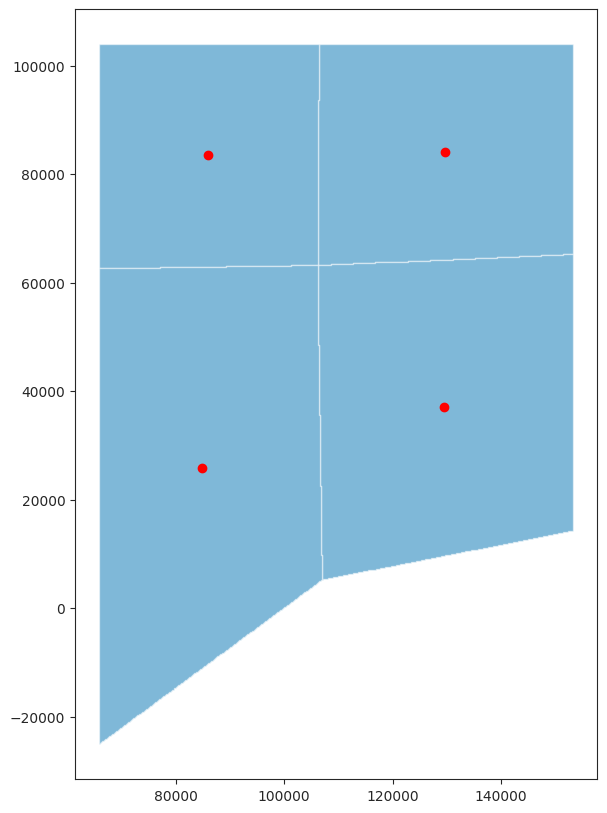

In [3]:
ax = RI_BA.plot(figsize=(20, 10), alpha=0.5)
RI_ENDPOINTS.plot(ax=ax, color="red")

Using these regions, we can set up a routing class instance:

In [4]:
rcx = RegionalXmission(
    COST_H5, FEATURES, regions=RI_BA, region_identifier_column="ba_str"
)

/home/ppinchuk/.local/lib/python3.11/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/kfs2/projects/rev/environments/.ppce/gh/reVX/reVX/least_cost_xmission/least_cost_xmission.py:365: UserWarning: The following features are outside of the cost exclusion domain and will be dropped:
18      68365
19      68423
20      68592
21      68650
22      68791
        ...  
1166    69303
1167    69311
1168    69317
1169    69325
1170    69348
Name: trans_gid, Length: 459, dtype: int64
  warn(msg)


Now let's read in and examine our transmission features:

In [5]:
ri_feats = gpd.read_file(FEATURES)
ri_feats.head()

,ac_cap,bgid,cap_left,category,egid,gid,voltage,trans_gids,geometry
0,1260.0,68414.0,126.0,TransLine,68424.0,43951,276.0,null,"MULTILINESTRING ((8934.906 114018.852, 9385.67..."
1,145.0,68863.0,14.5,TransLine,68864.0,43862,4.0,null,"MULTILINESTRING ((98665.079 108483.327, 98867...."
2,545.0,68690.0,54.5,TransLine,68685.0,47854,345.0,null,"MULTILINESTRING ((48399.257 53002.509, 48327.0..."
3,50.0,68768.0,5.0,TransLine,68770.0,47884,69.0,null,"MULTILINESTRING ((40332.502 -13229.919, 40386...."
4,145.0,68917.0,14.5,TransLine,68938.0,43681,115.0,null,"MULTILINESTRING ((125798.171 158253.494, 12590..."


In [6]:
ri_feats.category.value_counts()

category
TransLine     606
Substation    445
LoadCen       118
PCALoadCen      2
Name: count, dtype: int64

We can filter these features down to transmission lines and substations - we won't examine connections to anything else in this example

In [7]:
ri_substations = ri_feats[ri_feats.category == "Substation"].reset_index(
    drop=True
)
ri_tlines = ri_feats[ri_feats.category == "TransLine"].reset_index(
    drop=True
)

Let's now plot our transmission features on top of teh regions we created, as well as teh reV supply curve points that we will be routing from:

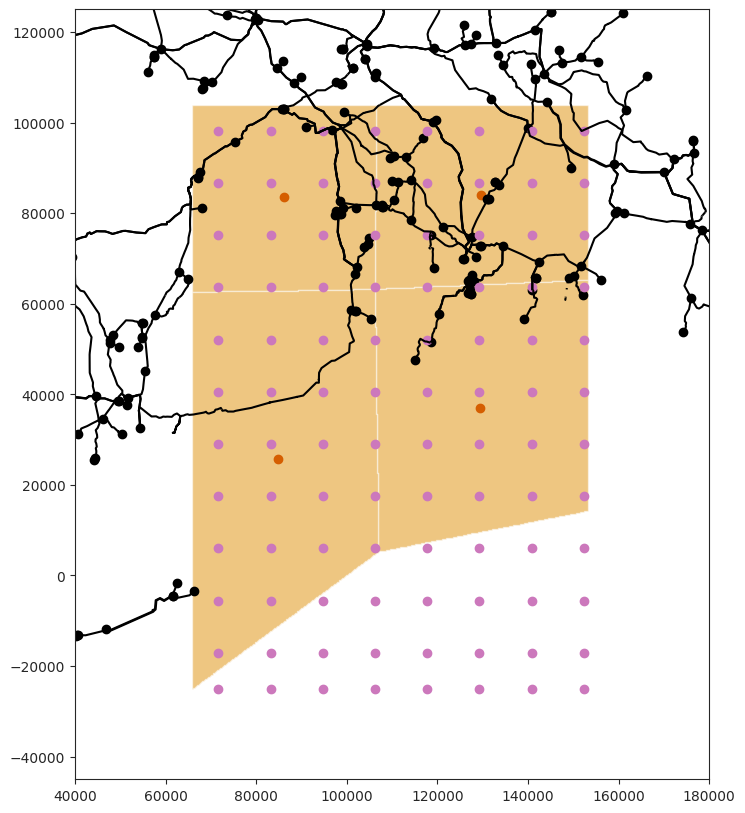

In [8]:
ax = RI_BA.plot(figsize=(20, 10), alpha=0.5, color="C1")
RI_ENDPOINTS.plot(ax=ax, color="C3")
ri_substations.centroid.plot(ax=ax, color="black")
ri_tlines.plot(ax=ax, color="black")
rcx.sc_points.plot(ax=ax, color="C4")

plt.xlim(40_000, 180_000)
plt.ylim(-45_000, 125_000);

For example purposes, let's limit our analysis to the top-right region:

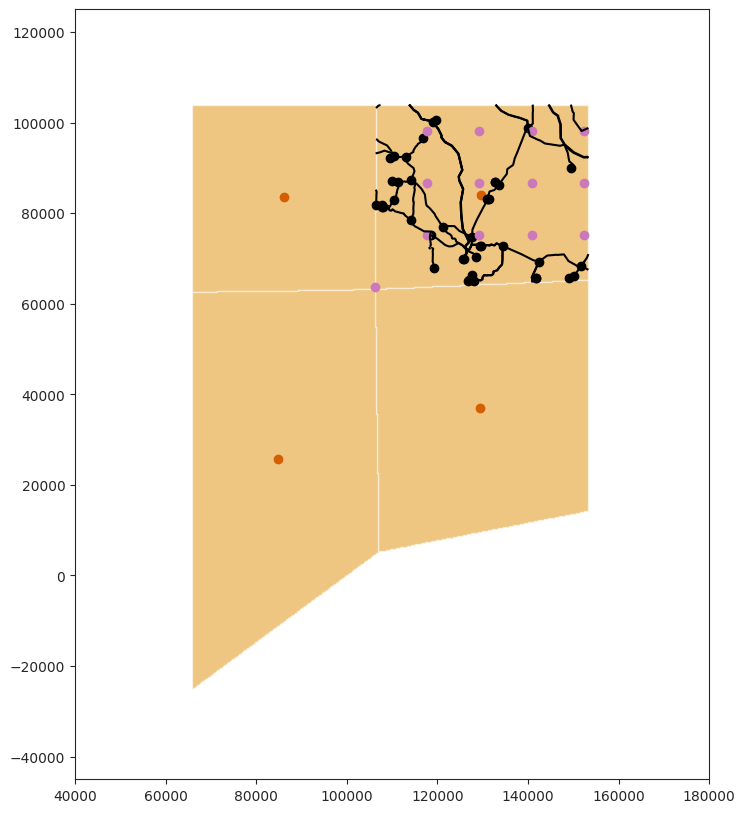

In [9]:
ri_p4 = RI_BA.iloc[[0]]

clipped_substations = gpd.clip(ri_substations.to_crs(RI_BA.crs), ri_p4)
clipped_tlines = gpd.clip(ri_tlines.to_crs(RI_BA.crs), ri_p4)
clipped_sc_points = gpd.clip(rcx.sc_points.to_crs(RI_BA.crs), ri_p4)

ax = RI_BA.plot(figsize=(20, 10), alpha=0.5, color="C1")
RI_ENDPOINTS.plot(ax=ax, color="C3")
clipped_substations.centroid.plot(ax=ax, color="black")
clipped_tlines.plot(ax=ax, color="black")
clipped_sc_points.plot(ax=ax, color="C4")

plt.xlim(40_000, 180_000)
plt.ylim(-45_000, 125_000);

And let's get a closer look at this region:

<Axes: >

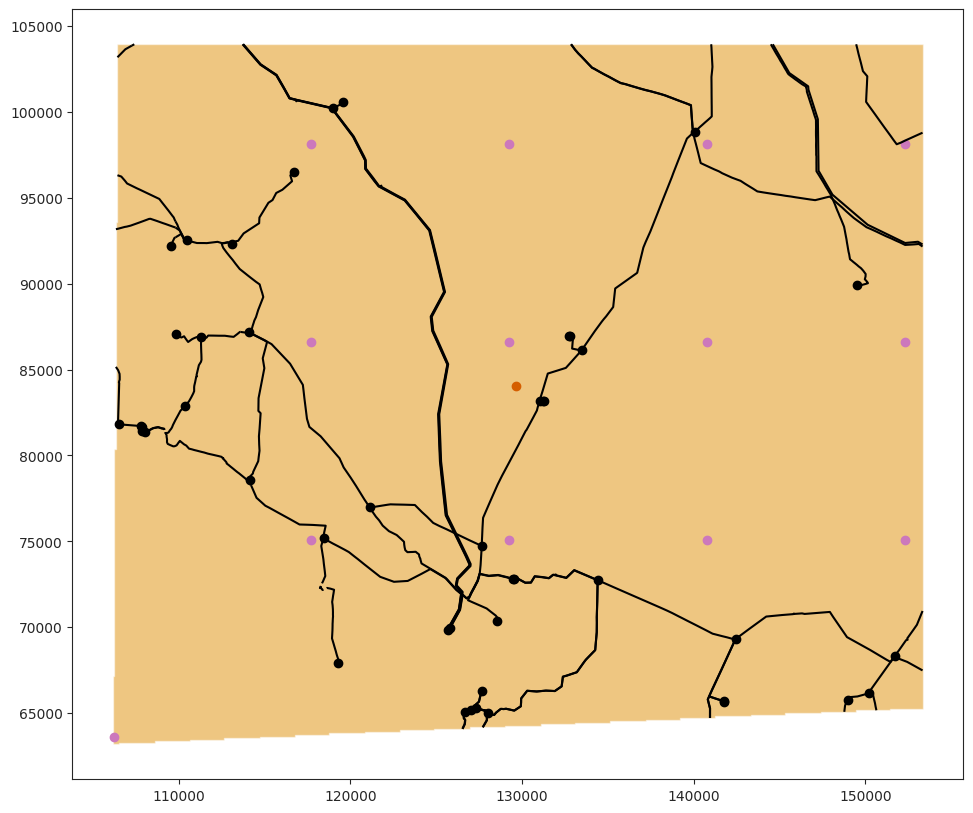

In [10]:
ri_p4 = RI_BA.iloc[[0]]

clipped_endpoints = gpd.clip(RI_ENDPOINTS, ri_p4)
clipped_substations = gpd.clip(ri_substations.to_crs(RI_BA.crs), ri_p4)
clipped_tlines = gpd.clip(ri_tlines.to_crs(RI_BA.crs), ri_p4)
clipped_sc_points = gpd.clip(rcx.sc_points.to_crs(RI_BA.crs), ri_p4)

ax = ri_p4.plot(figsize=(20, 10), alpha=0.5, color="C1")
clipped_endpoints.plot(ax=ax, color="C3")
clipped_substations.centroid.plot(ax=ax, color="black")
clipped_tlines.plot(ax=ax, color="black")
clipped_sc_points.plot(ax=ax, color="C4")

Let's select a reV supply curve point to examine. We will tell teh routing code to only consider transmission features within 25km of this point:

In [11]:
sc_point = clipped_sc_points.iloc[9]
gid = sc_point['sc_point_gid']
tie_line_voltage = rcx._config.capacity_to_kv(400)
sc_features_r, sc_radius_r = rcx._clip_to_sc_point(
    sc_point, tie_line_voltage, nn_sinks=2,
    clipping_buffer=1.1, radius=25_000 / 90,
    expand_radius=True
)

<Axes: >

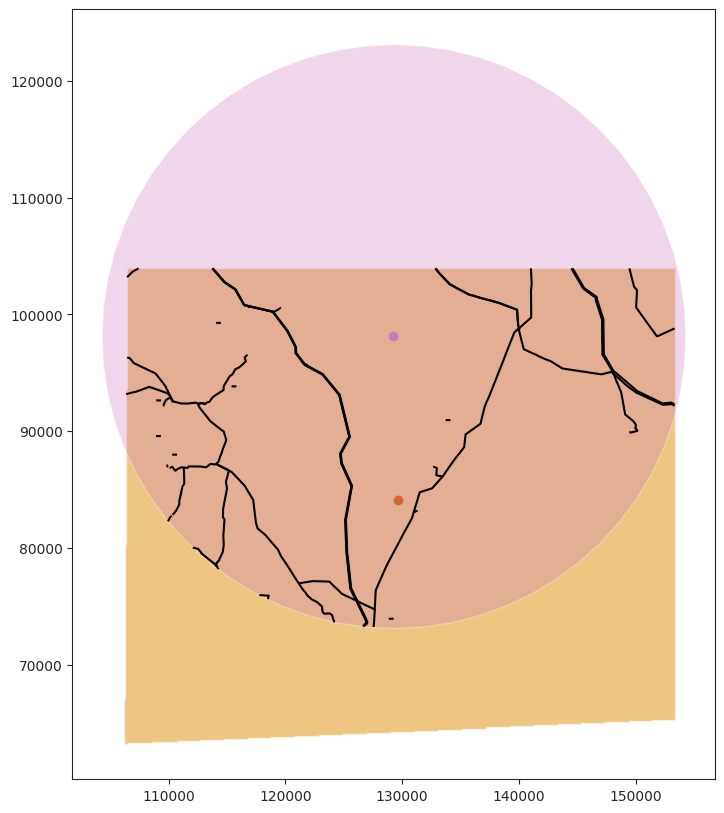

In [12]:
ax = ri_p4.plot(figsize=(20, 10), alpha=0.5, color="C1")
clipped_endpoints.plot(ax=ax, color="C3")
sc_features_r.plot(ax=ax, color="black")
gpd.GeoDataFrame([sc_point], geometry="geometry").plot(ax=ax, color="C4")

gpd.GeoDataFrame([sc_point], geometry="geometry").buffer(25000).plot(ax=ax, color="C4", alpha=0.3)

The routing itself will happen through a cost raster. Let's set up a routing class to get access to these costs and plot them:

In [13]:
tcc = RegionalTransCapCosts(
    COST_H5,
    sc_point,
    sc_features_r,
    400,
    ["tie_line_costs_400MW"],
    radius=sc_radius_r,
    xmission_config=rcx._config,
    barrier_mult=100,
    length_invariant_cost_layers=None,
)


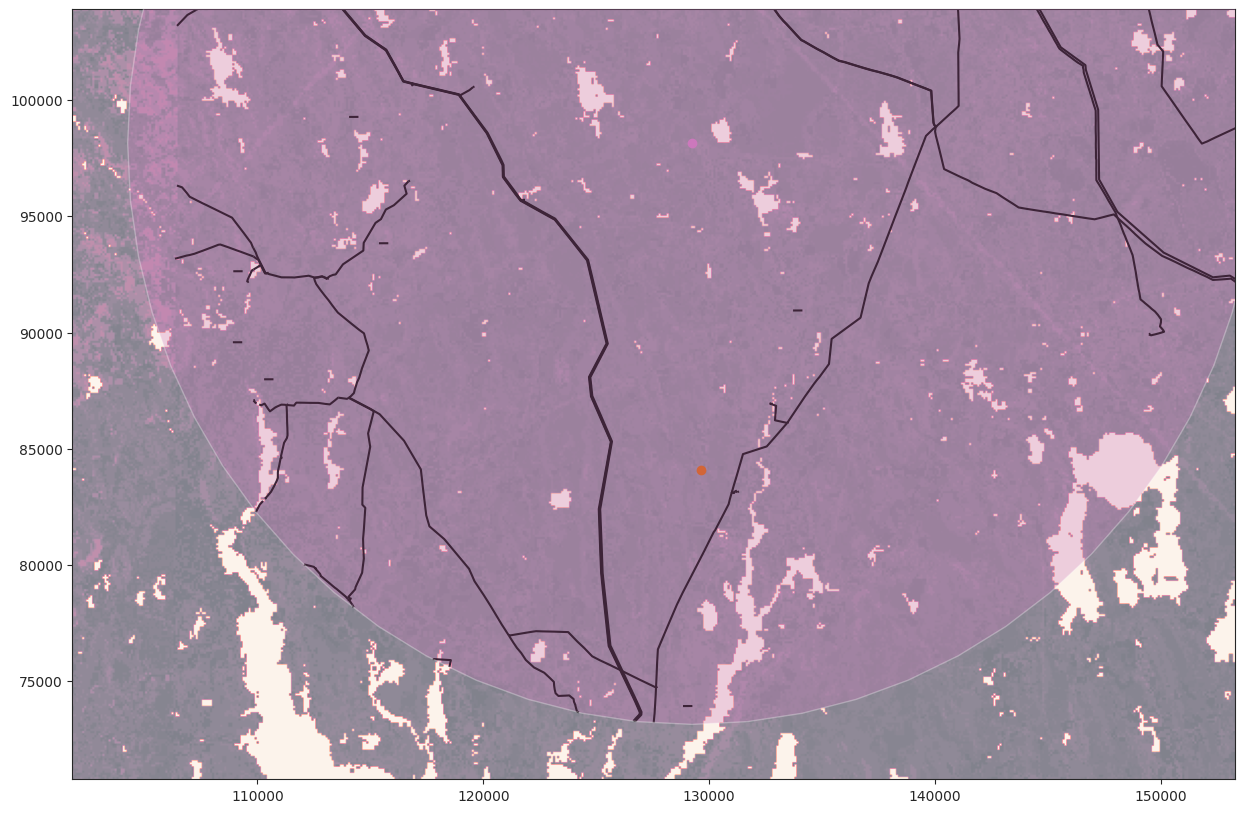

In [14]:
ax = sc_features_r.plot(color="black", figsize=(15, 10))
clipped_endpoints.plot(ax=ax, color="C3")
gpd.GeoDataFrame([sc_point], geometry="geometry").plot(ax=ax, color="C4")

gpd.GeoDataFrame([sc_point], geometry="geometry").buffer(25000).plot(ax=ax, color="C4", alpha=0.3, zorder=10)

minx, miny, maxx, maxy = tcc.clip_mask.bounds

ax.imshow(
    tcc.cost,
    extent=[minx, maxx, miny, maxy],
    aspect="auto",
    alpha=0.5,
)

Now let's compute the paths!

In [15]:
out_features = tcc.compute(
    min_line_length=0, save_paths=True, simplify_geo=False
)

/kfs2/projects/rev/environments/.ppce/gh/reVX/reVX/least_cost_xmission/trans_cap_costs.py:1917: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.0615833349907333 1.0026442122930843 1.0053694162646534
 1.0012816103072997 1.004006814278869 1.3237604424802427 1.056931120810751
 1.128544506577324 1.128544506577324 1.1271819045915397 1.128544506577324
 1.3218334322718295 1.3256874526886557 1.2465029744873846
 1.2126149844991054 1.0119085293956676 1.094987139271146
 1.1678261786245496 1.0982767514653438 1.1514749547951346
 1.1818796583060696 1.1961669235281172 1.1961669235281172
 1.1547645669893323 1.3187776056181595 1.3187776056181595
 1.178590046111872]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  features.loc[mask, 'length_mult'] = (


Now we can examine all the connections that were made within the 25 km radius along our cost raster:

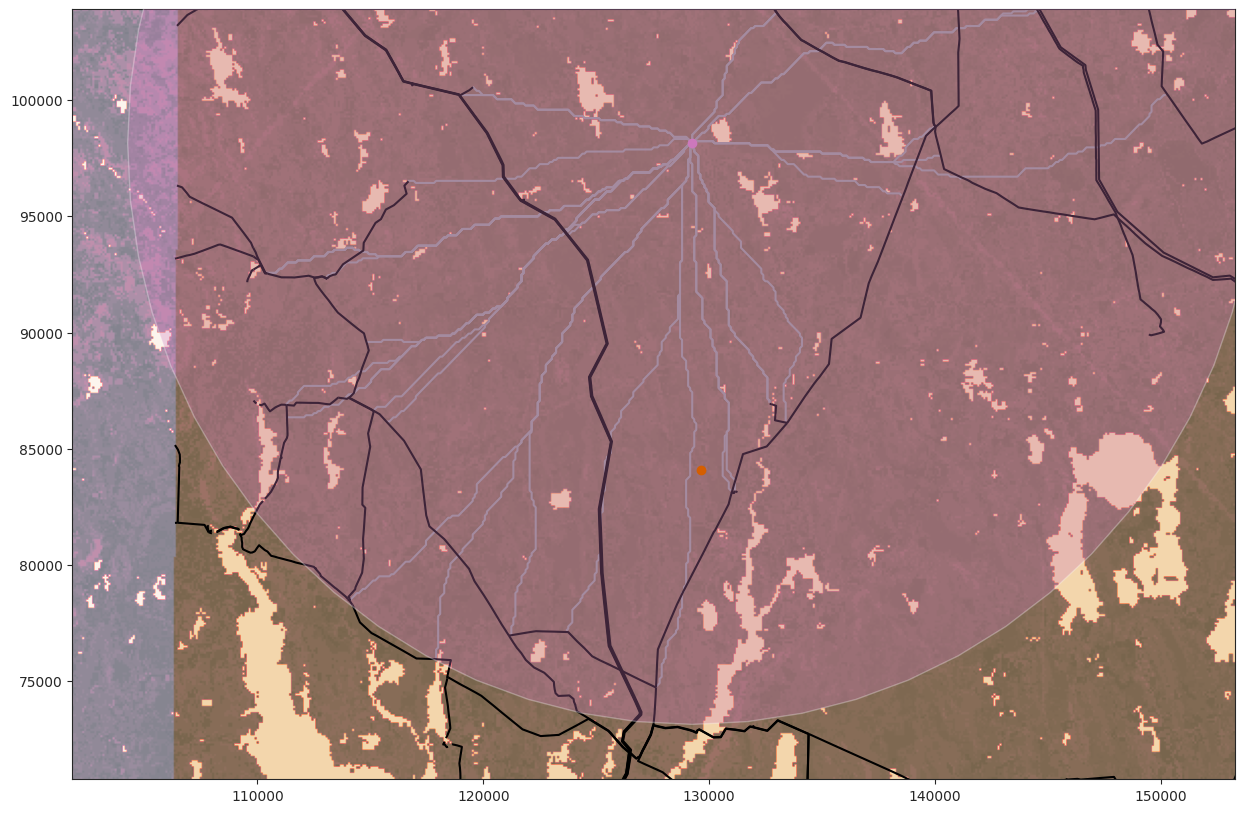

In [16]:
ax = ri_p4.plot(figsize=(15, 10), alpha=0.5, color="C1", zorder=0)
clipped_tlines.plot(ax=ax, color="black")
gpd.GeoDataFrame([sc_point], geometry="geometry").plot(
    ax=ax, color="C4", zorder=10
)
gpd.GeoDataFrame([sc_point], geometry="geometry").buffer(25000).plot(
    ax=ax, color="C4", alpha=0.3, zorder=10
)
clipped_endpoints.plot(ax=ax, color="C3", zorder=10)
out_features[out_features["category"] == "TransLine"].plot(
    ax=ax, color="C7", zorder=1
)

minx, miny, maxx, maxy = tcc.clip_mask.bounds

ax.imshow(
    tcc.cost,
    extent=[minx, maxx, miny, maxy],
    aspect="auto",
    alpha=0.5,
)

Feel free to use this notebook as a starting point to dive deeper into this example!